In [1]:
# Simulating dynamics of Argon atoms
# Starting with outlining general kinematics of particles

Week 1:
Play around with this system. Start by simulating the time evolution of a few particles in a periodic box, 
add the forces due to the Lennard-Jones potential. Check how the total energy of your system evolves over time.
It's easier to start with a 2D system, but plan to switch to 3D at a later stage.
Week 2:
Derive the expression of the kinetic energy in dimensionless units
Write a molecular dynamics code that uses dimensionless units and simulate a few atoms. 
Plot both kinetic, potential and total energy.
Boundary condition, minimal image convention

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [3]:
'''Parameters given in dimensionless units of sigma
 Perhaps convert between units later'''
# Variables
# Argon
# epsilon = const.k_B * 119.8*u.K
# sigma = 3.405*u.AA
# mass = 39.948*u.u

L = 10.0

In [4]:
# Lennard-Jones potential 
def LJP(r):
    '''Lennard-Jones potential formula
    Describes the potential of the system given a distance between two particles
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return 4*(1/(r**12.) - 1/(r**6.))

def dUdr(r):
    ''' Derivative of LJP WRT r
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return -48./(r**13.) + 24/(r**7.)

def norm(r):
    ''' Calculate the magnitude/norm of a vector r'''
    return np.sqrt(np.sum(r**2.0))

def acceleration(derivU, r):
    '''Force from LJP potential
    derivU from function dUdr
    r is magnitude (dimensionless)'''
    nablaU = derivU * r / norm(r)
    return -nablaU

# New velocity
def next_velocity(v_prev, a, t):
    '''Finding the next velocity value
    previous velocity v_prev
    acceleration a at x_prev
    timestep t
    Dimensionless units'''
    return v_prev + a*t

def apply_boundary_conditions(x):
    '''Apply boundary conditions for a box of size L x L x L to position x'''
    for d in range(3):
        if (x[d] < 0.0):
            x[d] = L - x[d]
        elif (x[d] > L):
            x[d] = x[d] - L
    
    return x

# New position given a timestep
def next_position(x_prev, v_prev, t):
    '''The next position value
    previous position x_prev
    previous velocity v_prev
    timestep t
    Dimensionless units'''
    return apply_boundary_conditions(x_prev + v_prev*t)

In [5]:
# The force at x is the negative gradient of the potential at x
# The gradient of the potential is the derivative of the potential WRT r times x/r
# where r is the magnitude of the distance and x is a vector

# Initial conditions
h = 0.05 # time step
num_time = 40  # number of time steps
num_part = 2

x_i_init = np.array([1.0, 9.0, 0.0]) # initial position vector of particle i
v_i_init = np.array([1.0, 1.0, 0.0]) # initial velocity vector of particle i

x_j_init = np.array([9.0, 1.0, 0.0])
v_j_init = np.array([0.0, 0.0, 0.0])

In [6]:
#Test
# next_v = next_velocity(v_init, acc, h)
# print(next_v)
# next_x = next_position(x_init, v_init, h)
# print(next_x)

In [7]:
state = np.zeros((num_part, num_time, 6))  # state consists of 6 degrees of freedom: 3 position coordinates, 3 velocities

# store the initial state of the system
state[0, 0, :3] = x_i_init
state[0, 0, 3:] = v_i_init
state[1, 0, :3] = x_j_init
state[1, 0, 3:] = v_j_init

# store the kinetic and potential energy of 2 particles in 3 dimensions for num_time timesteps
E_kin = np.zeros((2, 3, num_time))
E_pot = np.zeros((num_time))
E_tot = np.zeros((num_time))

timesteps = range(1, num_time)

# box size
L = 10.0

# Change in position and velocity
for t in timesteps:
    
    # calculate the distance between the two particles    
    r = state[0, t-1, :3] - state[1, t-1, :3]
    r_norm = norm(r)
    
    # calculate the acceleration of both particles
    acc = acceleration(dUdr(r_norm), r)
    
    # let the system evolve for both particles
    v_next_i = next_velocity(state[0, t-1, 3:], acc, h)
    x_next_i = next_position(state[0, t-1, :3], state[0, t-1, 3:], h)
    v_next_j = next_velocity(state[1, t-1, 3:], acc, h)
    x_next_j = next_position(state[1, t-1, :3], state[1, t-1, 3:], h)
    state[0, t, :3] = x_next_i
    state[0, t, 3:] = v_next_i
    state[1, t, :3] = x_next_j
    state[1, t, 3:] = v_next_j
    
    # calculate the kinetic energy of the particles
    E_kin[0, :, t-1] = 0.5 * v_next_i ** 2.0
    E_kin[1, :, t-1] = 0.5 * v_next_j ** 2.0
    
    # calculate the potential energy
    E_pot[t-1] = LJP(r_norm)
    
    # the total energy is the sum of the kinetic energy of both particles and the potential energy
    E_tot[t-1] = E_pot[t-1] + E_kin[0, 0, t-1] + E_kin[1, 0, t-1]

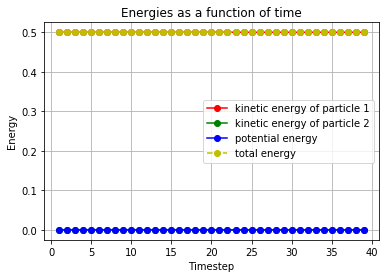

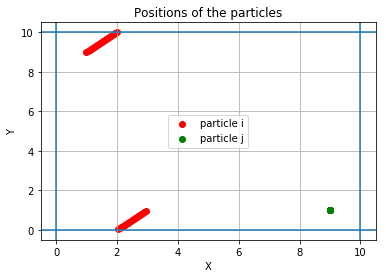

In [8]:
# plot the potential, kinetic and total energy
plt.title('Energies as a function of time')
plt.plot(timesteps, E_kin[0, 0, :-1], linestyle='-', marker='o', c='r', label='kinetic energy of particle 1')
plt.plot(timesteps, E_kin[1, 0, :-1], linestyle='-', marker='o', c='g', label='kinetic energy of particle 2')
plt.plot(timesteps, E_pot[:-1], linestyle='-', marker='o', c='b', label='potential energy')
plt.plot(timesteps, E_tot[:-1], linestyle='--', marker='o', c='y', label='total energy')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.grid()
plt.legend()

# plot the positions of both particles in a new figure
plt.figure()
plt.title('Positions of the particles')
plt.scatter(state[0, :, 0], state[0, :, 1], linestyle='-', marker='o', c='r', label='particle i')
plt.scatter(state[1, :, 0], state[1, :, 1], linestyle='-', marker='o', c='g', label='particle j')

# restrict the view around the box + a small margin
view_margin = 0.5
plt.xlim(-view_margin, L + view_margin)
plt.ylim(-view_margin, L + view_margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# add border lines around the box
plt.axvline(0)
plt.axvline(L)
plt.axhline(0)
plt.axhline(L)

plt.show()